In [43]:
import gzip
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Instructions for updating:
non-resource variables are not supported in the long term


In [44]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [45]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [46]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


In [47]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

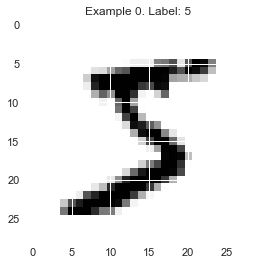

In [48]:
display_image(0)

In [49]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [50]:
# sns.catplot(x="Label", y="Count",
#             kind="bar",
#             data=dataframe_train_labels)

In [51]:
train['features'], train['labels'] = shuffle(train['features'], train['labels'])

In [52]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [53]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


In [54]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


In [68]:
EPOCHS = 10  #10
BATCH_SIZE = 12   #120

In [58]:
#from tensorflow.contrib.layers import flatten
from tensorflow.compat.v1.layers import flatten

n_classes = 10

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1    
    
    weights = {
        # The shape of the filter weight is (height, width, input_depth, output_depth)
        'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
        'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
        'fl1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 16, 120), mean = mu, stddev = sigma)),
        'fl2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    }

    biases = {
        # The shape of the filter bias is (output_depth,)
        'conv1': tf.Variable(tf.zeros(6)),
        'conv2': tf.Variable(tf.zeros(16)),
        'fl1': tf.Variable(tf.zeros(120)),
        'fl2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_classes))
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['conv1'])
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['conv2'])
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fl0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fl1 = tf.add(tf.matmul(fl0, weights['fl1']), biases['fl1'])
    # Activation.
    fl1 = tf.nn.relu(fl1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fl2 = tf.add(tf.matmul(fl1, weights['fl2']), biases['fl2'])
    # Activation.
    fl2 = tf.nn.relu(fl2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fl2, weights['out']), biases['out'])
                 
    return logits

In [59]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [60]:
learning_rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [61]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples

In [69]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_examples = len(train['features'])
    
    print("Training LeNet...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(train['features'], train['labels'])
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(validation['features'], validation['labels'])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    train_file_writer = tf.summary.FileWriter('logs', session.graph)
    train_file_writer.close()
    
    saver.save(session, './lenet')
    print("Model saved")

Training LeNet...

EPOCH 1 ...
Validation Accuracy = 0.977

EPOCH 2 ...
Validation Accuracy = 0.976

EPOCH 3 ...
Validation Accuracy = 0.984

EPOCH 4 ...
Validation Accuracy = 0.984

EPOCH 5 ...
Validation Accuracy = 0.982

EPOCH 6 ...
Validation Accuracy = 0.985

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.985

EPOCH 9 ...
Validation Accuracy = 0.987

EPOCH 10 ...
Validation Accuracy = 0.986

Model saved


In [70]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test['features'], test['labels'])
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.985
